# Project 3: Poisonous mushrooms

W207  <br />
Class: Thursday 6:30-8 PDT <br />
Student: Clayton Leach

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline

import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from sklearn.metrics import accuracy_score

Load feature names.

In [2]:
feature_names = []

# Changed file path to match what I need; will need to adjust when grading
with open('mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print ('Loaded feature names:', len(feature_names))

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

In [4]:
def pca_data(data, num_components):
    """
    Transform data into principle components
    :param data: data features which will be used to calculate eigenvectors
    :param num_components: The desired number of principle components
    """
    
    # Create PCA object and transform raw data
    pca = PCA(n_components=num_components)
    new_data = pca.fit_transform(data)
    
    # Print the percentage of original variance still captured by our new features
    per_variance = sum(pca.explained_variance_ratio_)
    
    return pca, per_variance, new_data

k_vals = [x for x in range(1,51)]

# Loop through possible values for num_components
for val in k_vals:
    _, variance_explained, _ = pca_data(train_data, val)
    print("When we took the top %s values we explained %s of the total variance" %(val,variance_explained))


When we took the top 1 values we explained 0.16404331279334214 of the total variance
When we took the top 2 values we explained 0.29727810148780853 of the total variance
When we took the top 3 values we explained 0.39901266670914115 of the total variance
When we took the top 4 values we explained 0.4696462310540682 of the total variance
When we took the top 5 values we explained 0.508312632829434 of the total variance
When we took the top 6 values we explained 0.5451207208062159 of the total variance
When we took the top 7 values we explained 0.5764028981910979 of the total variance
When we took the top 8 values we explained 0.6037403365827508 of the total variance
When we took the top 9 values we explained 0.6299049117796338 of the total variance
When we took the top 10 values we explained 0.6522146967073008 of the total variance
When we took the top 11 values we explained 0.6726957252813253 of the total variance
When we took the top 12 values we explained 0.6913780697715614 of the to

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

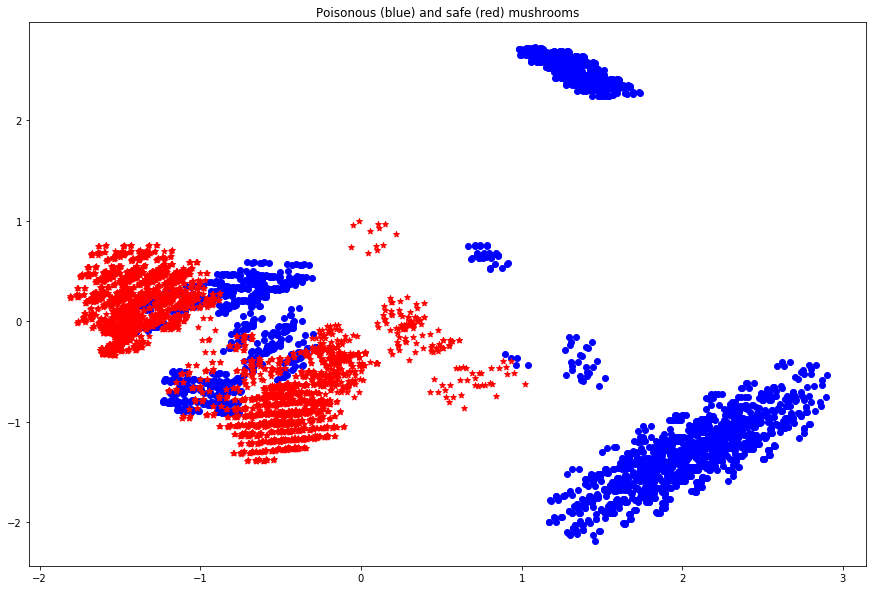

In [5]:
# Use prior function to generate 2 principle components and the PCA object
pca_object, _, df = pca_data(train_data,2)

def plot_pca_2d(df, labels):
    """
    Plots two dimensional feature data for a binary classification problem
    :param df: data for 2 features
    :param labels: corresponding binary labels
    """
    two_dim_x_positive = []
    two_dim_y_positive = []

    two_dim_x_negative = []
    two_dim_y_negative = []

    for x in range(0,df.shape[0]):
        temp_vals = df[x]
        if labels[x] == 1:
            two_dim_x_positive.append(temp_vals[0])
            two_dim_y_positive.append(temp_vals[1])
        else:
            two_dim_x_negative.append(temp_vals[0])
            two_dim_y_negative.append(temp_vals[1])
            
    plt.figure(figsize=(15,10))
    plt.scatter(two_dim_x_positive,two_dim_y_positive, c='b')
    plt.scatter(two_dim_x_negative,two_dim_y_negative, c='r', marker= '*')
    plt.title("Poisonous (blue) and safe (red) mushrooms")
    plt.show()
    
plot_pca_2d(df, train_labels)

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

In [6]:
def compute_distance(center, point):
    """Helper function to compute distance"""
    distance = math.sqrt((center[0]-point[0])**2 + (center[1]-point[1])**2)
    return distance

def k_means_clustering(df, num_clusters, increment=True):
    """
    Clusters based on df; if increment is True, solves clustering for all values of clusters
    where value is less than parameter "num_clusters".  Calls plot function to map results
    
    :param df: feature values
    :param num_clusters: number of clusters to be used in Kmeans
    :param increment: default True; if True loops through process for all values of num_clusters 
                        from 1 up and including num_clusters
    
    """
    if (num_clusters < 1) or (isinstance(num_clusters,int) == False):
        return "Invalid cluster number"
    if not increment:
        kmeans = KMeans(n_clusters=num_clusters, init="k-means++", random_state=0).fit(df)
    else:
        for x in range(1,num_clusters+1):
            kmeans = KMeans(n_clusters=x, init="k-means++", random_state=0).fit(df)
            cluster_dict = {}
            for x in range(0,df.shape[0]):
                point = df[x]
                cluster_label = kmeans.labels_[x]
                centroid = kmeans.cluster_centers_[cluster_label]
                dist = compute_distance(centroid,point)
                
                # If calculated distance is greater than current greatest point add it to the dictionary
                if (cluster_label not in cluster_dict) or (dist>cluster_dict[cluster_label]["distance"]):
                    cluster_dict[cluster_label] = {"point":point,"distance":dist, "centroid": centroid}
            plot_pca_2d_centroids(df, cluster_dict, kmeans)
    return

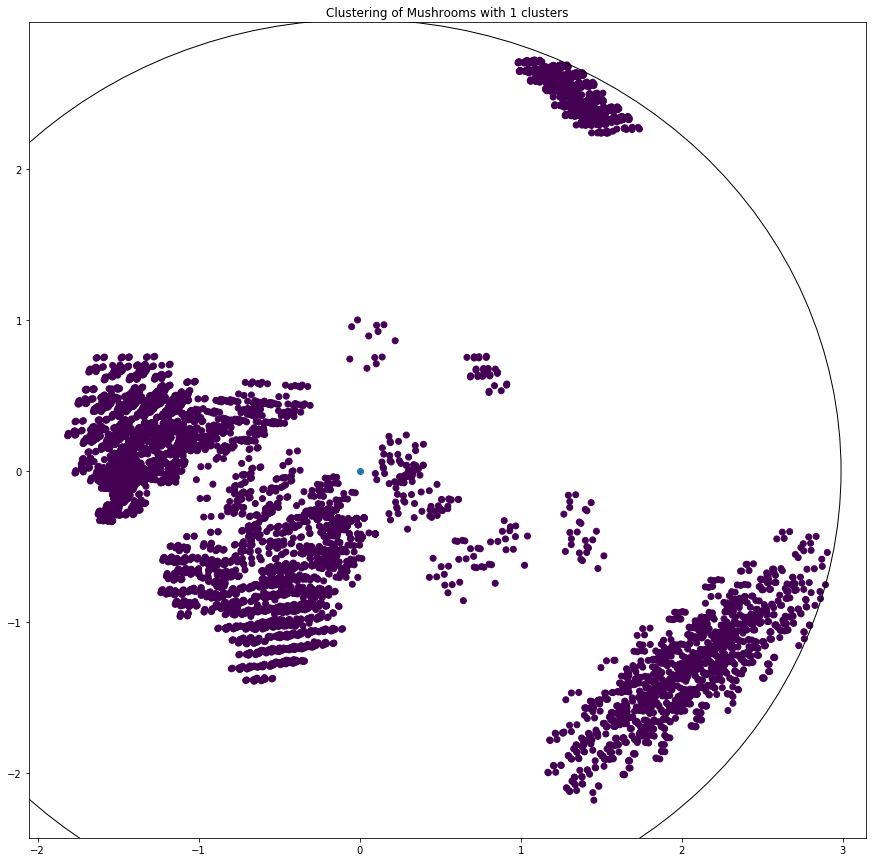

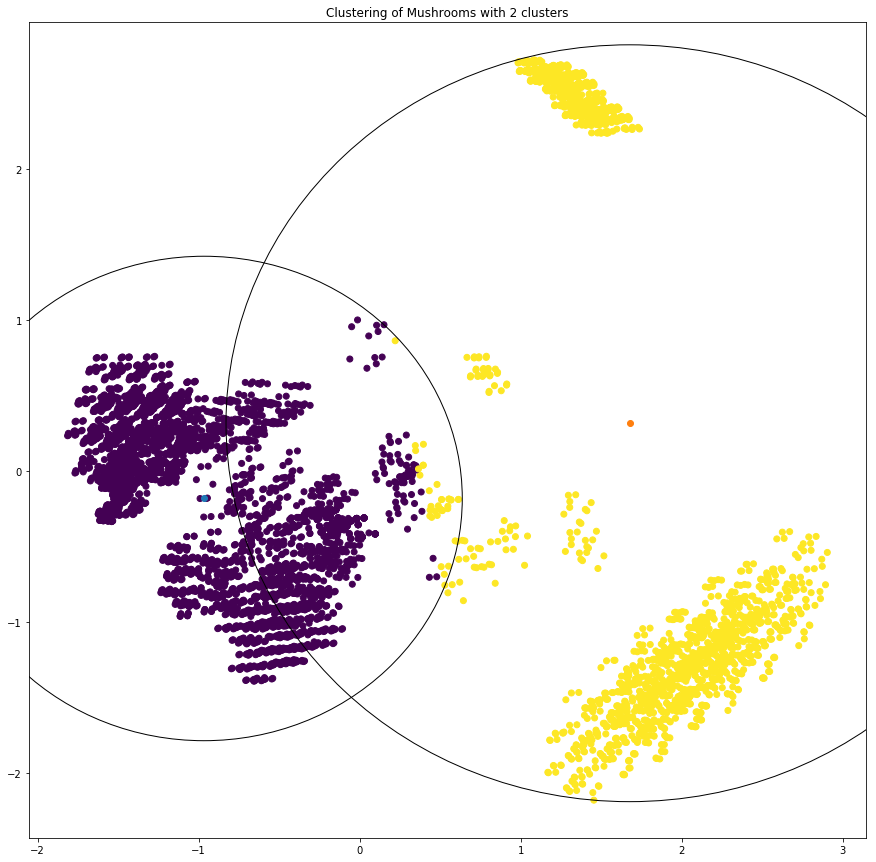

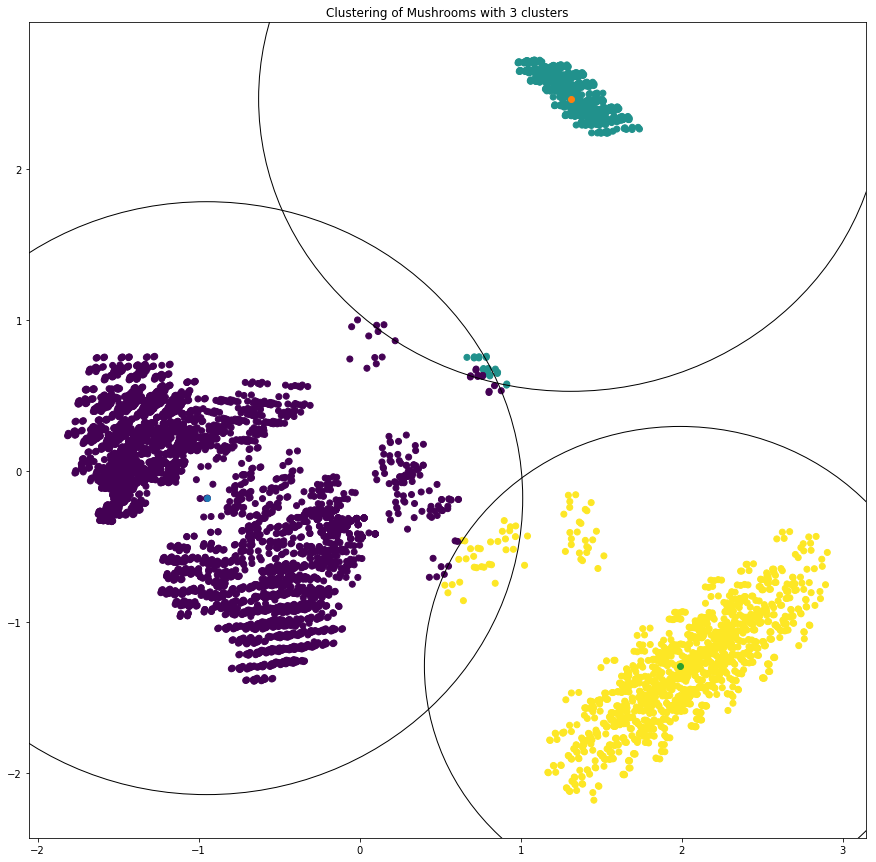

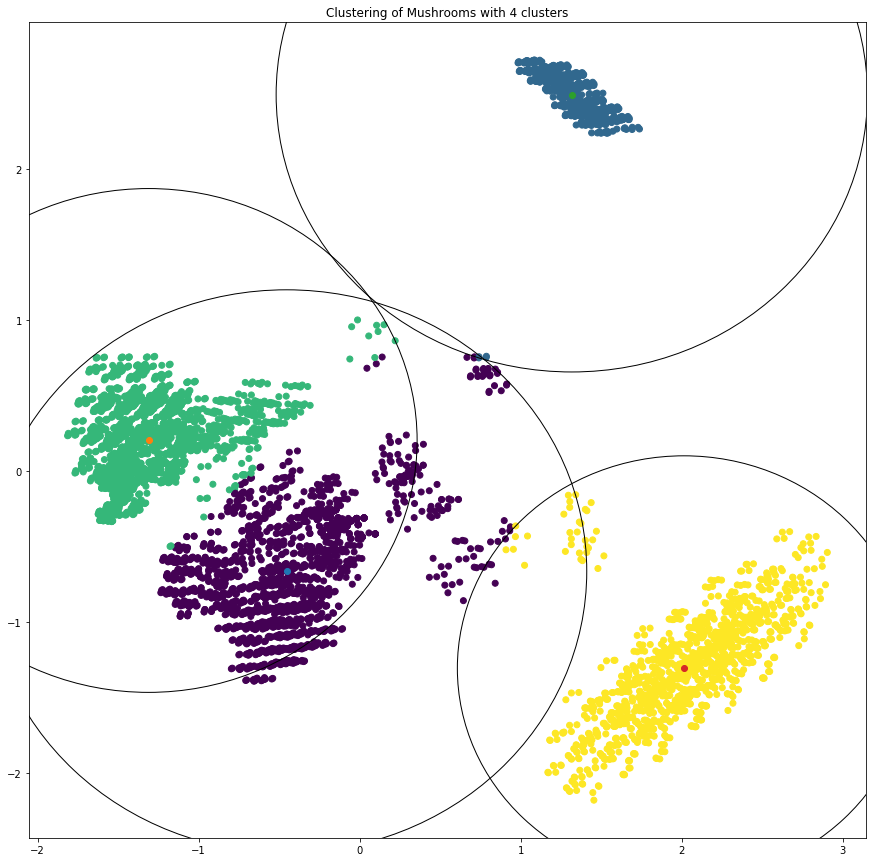

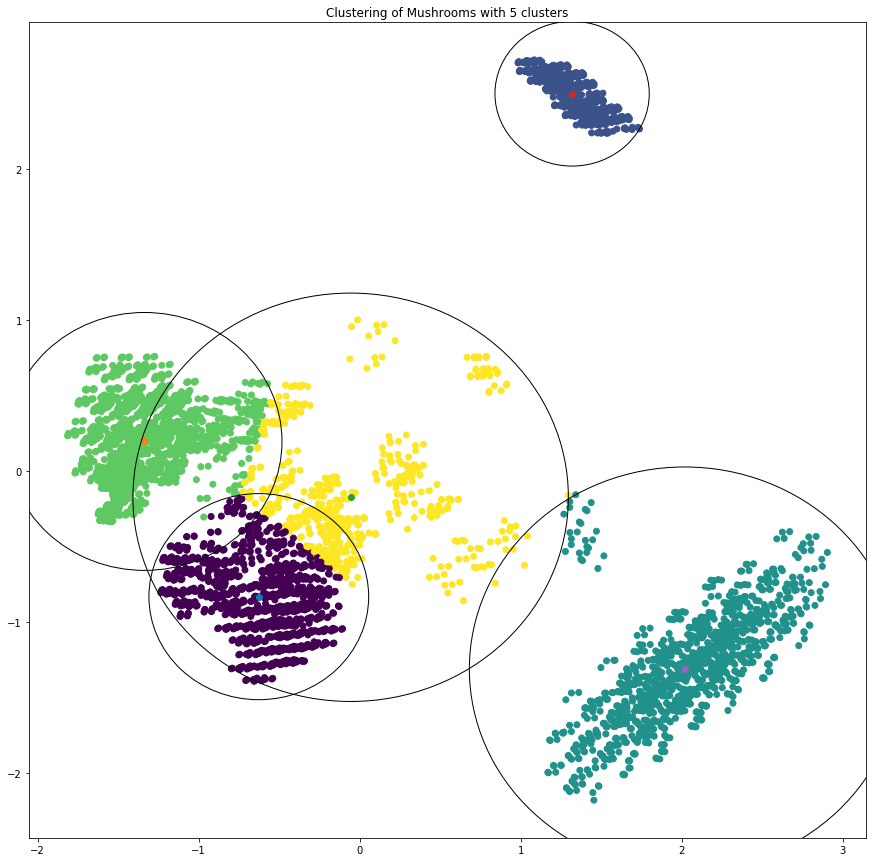

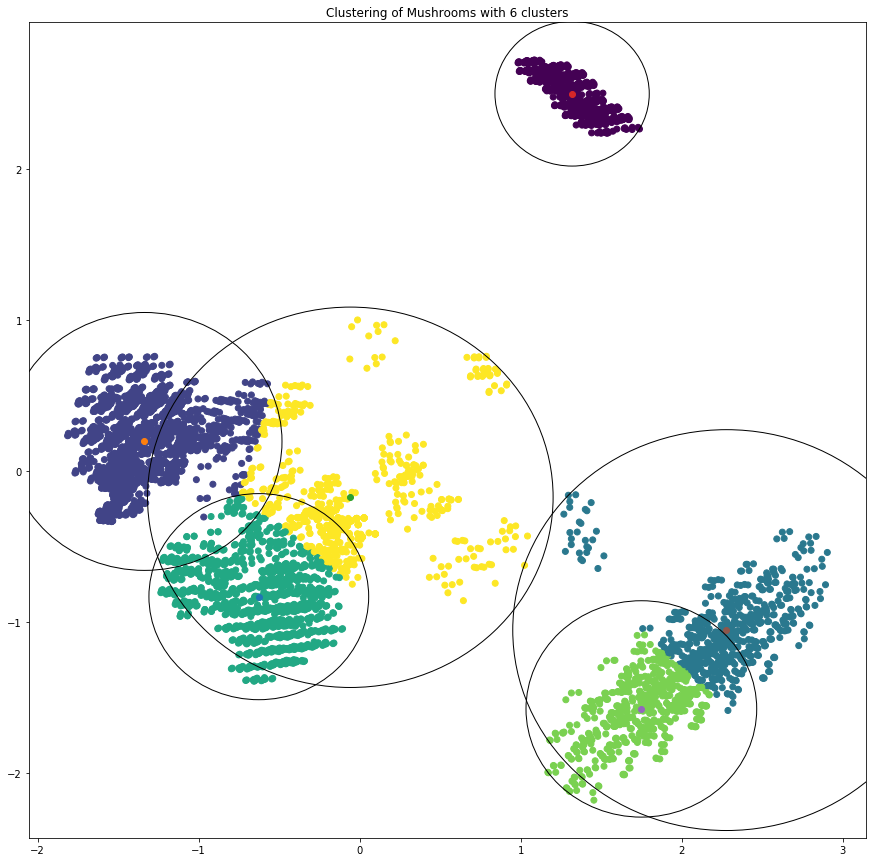

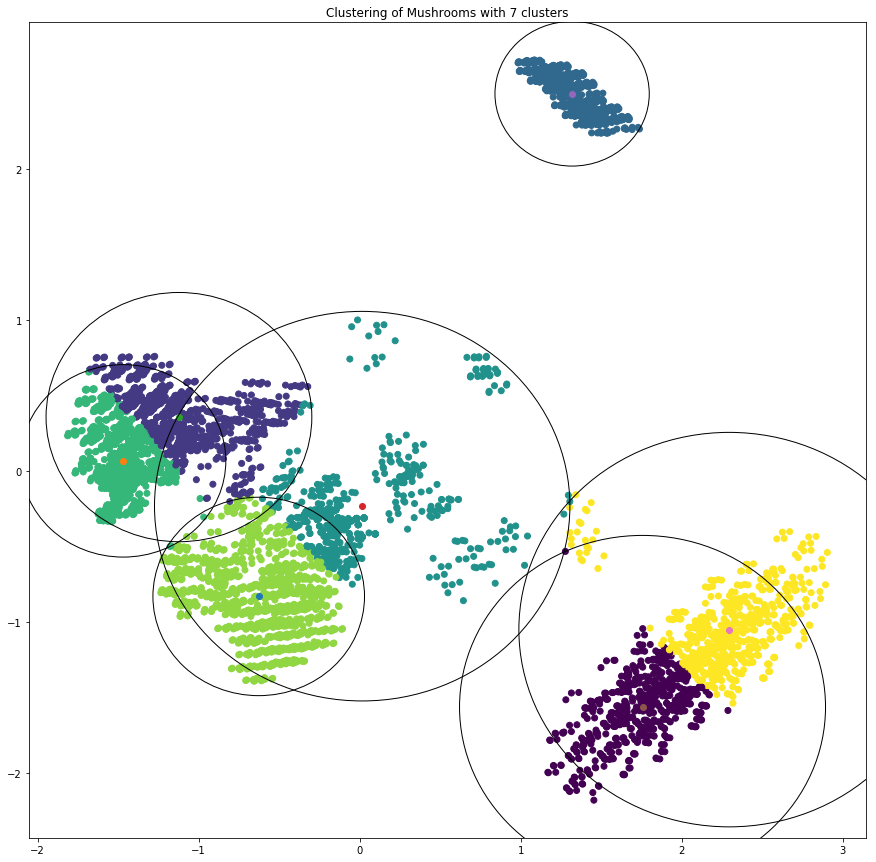

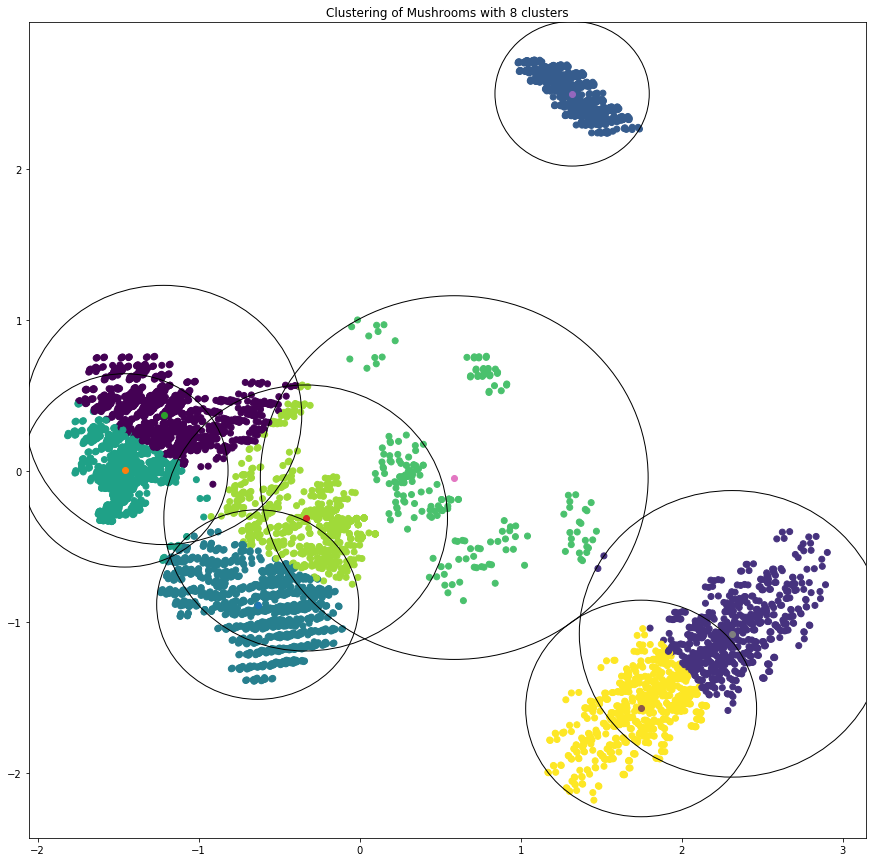

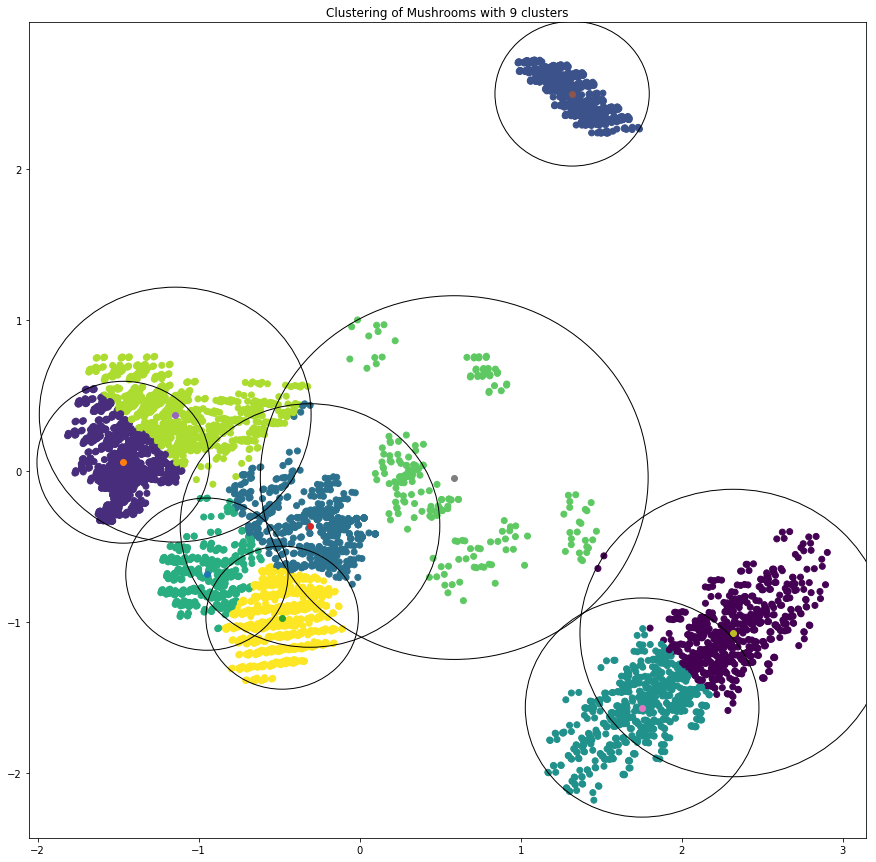

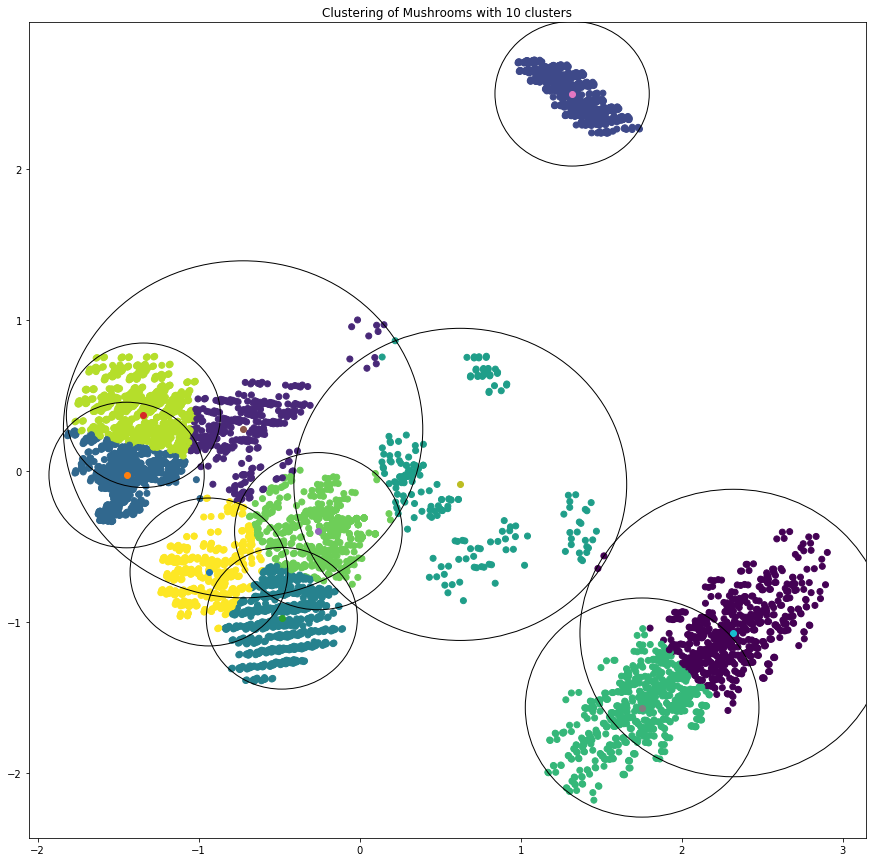

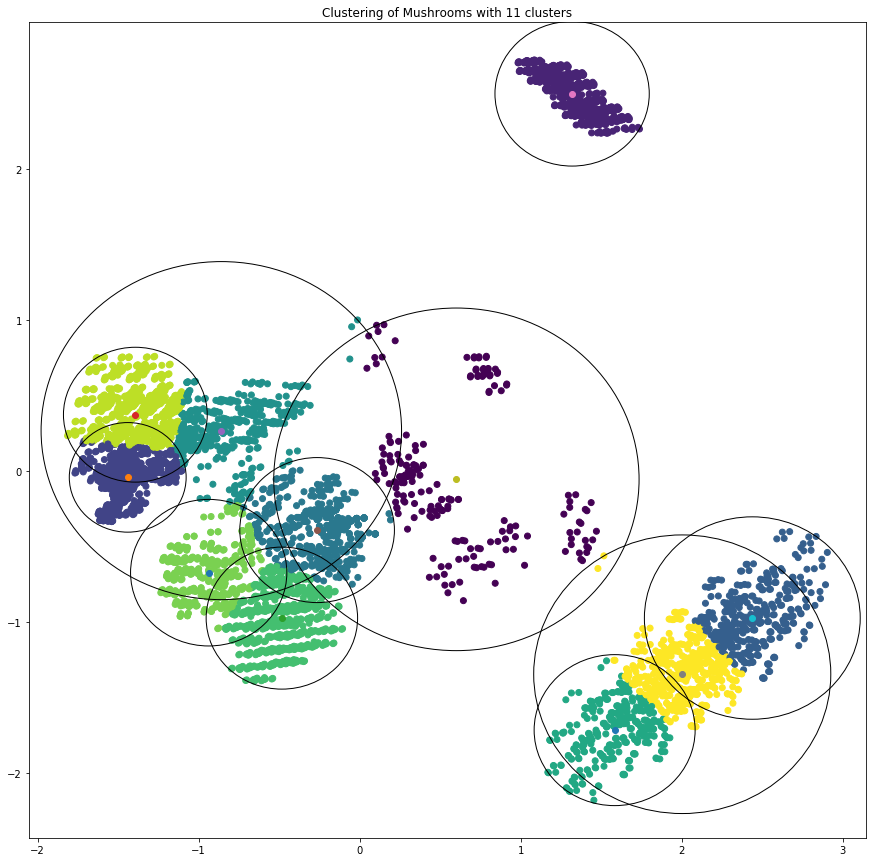

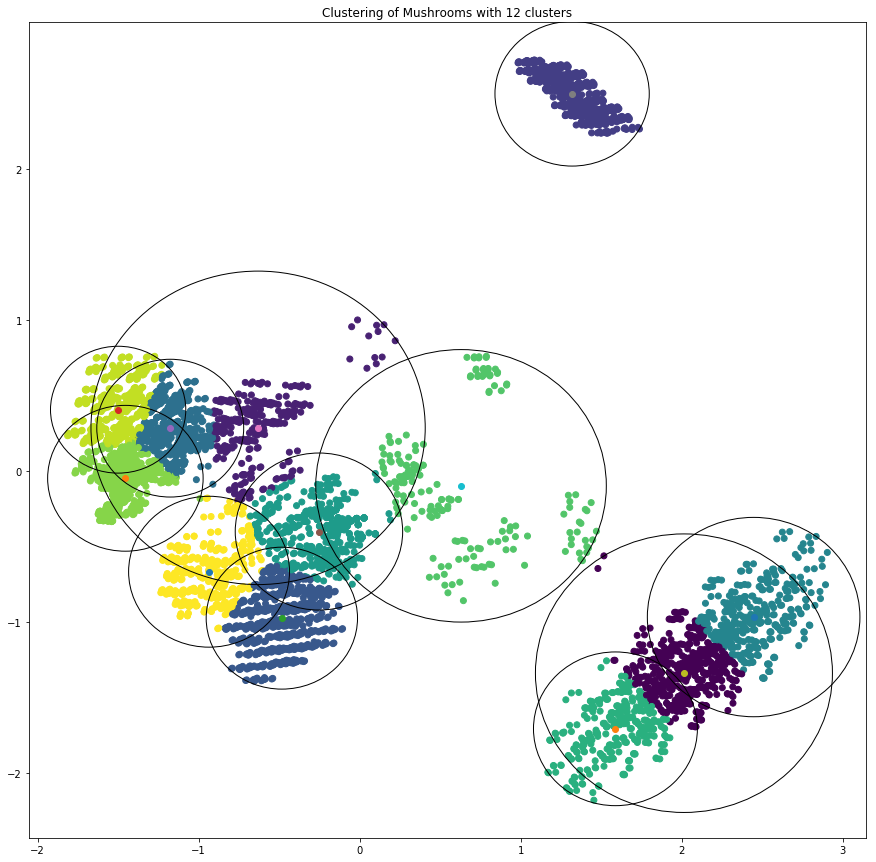

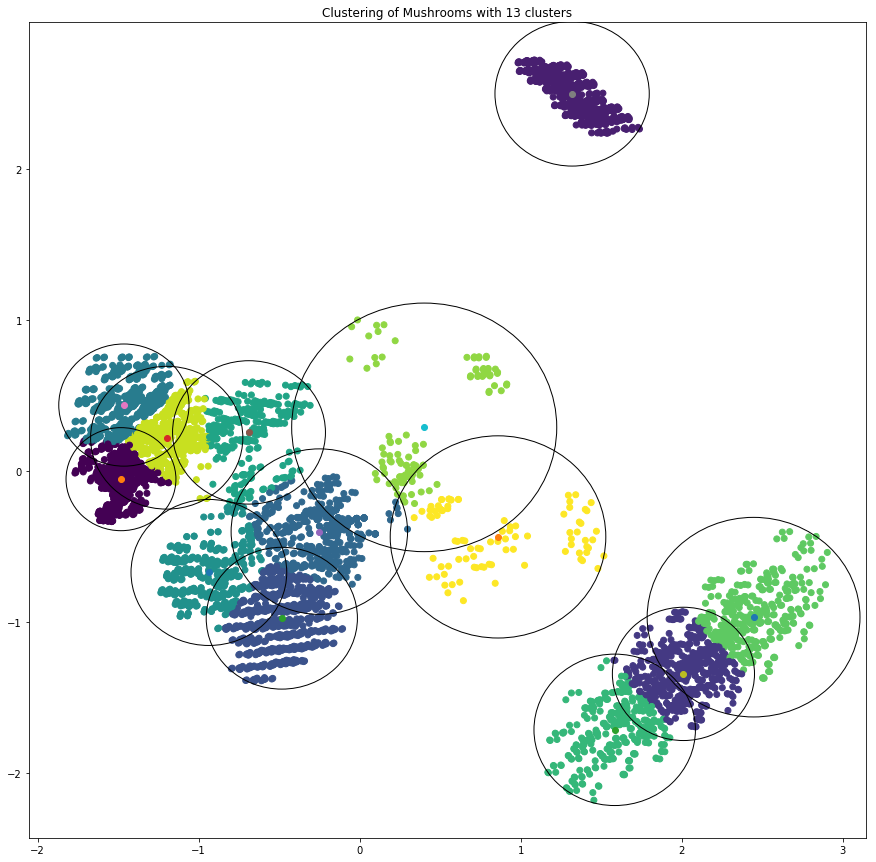

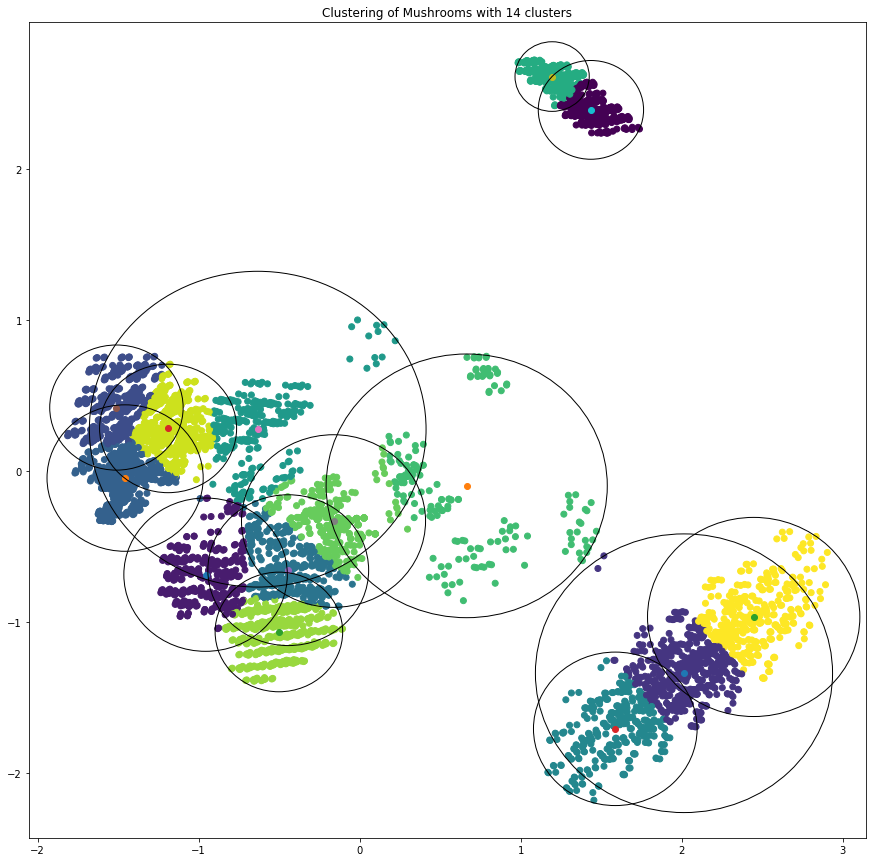

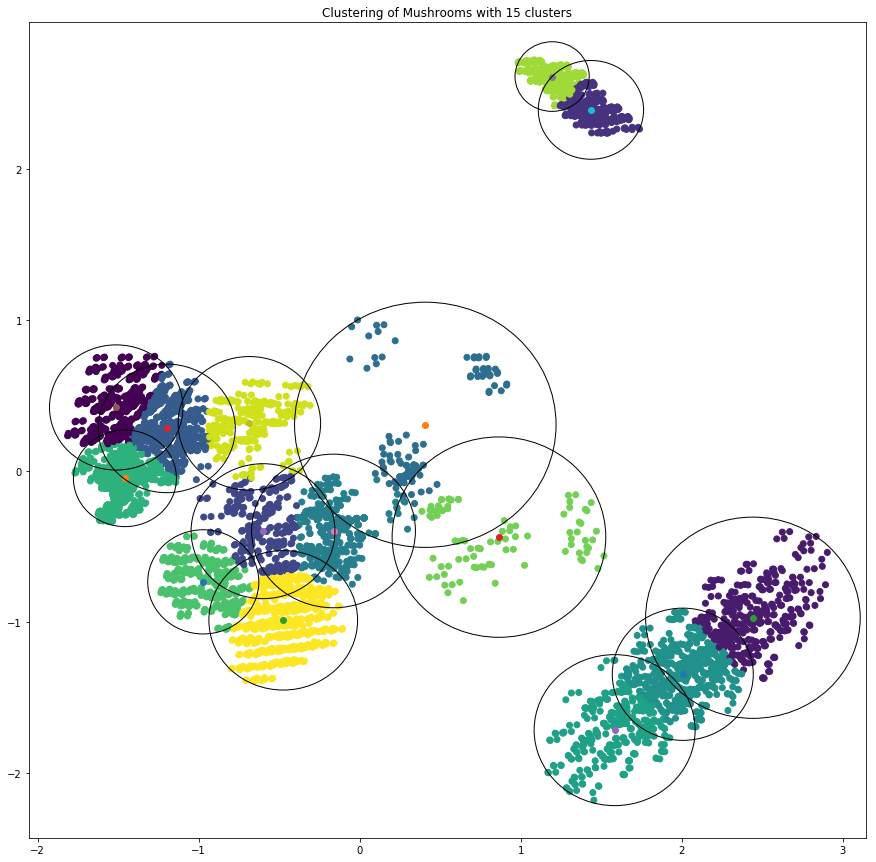

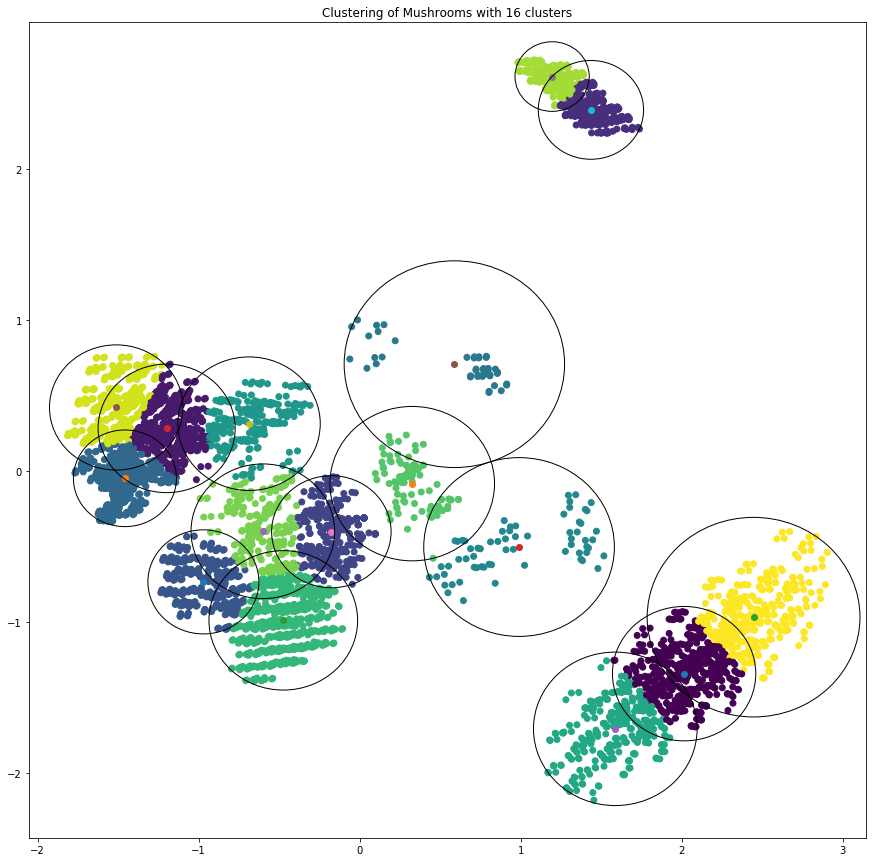

In [7]:
def plot_pca_2d_centroids(df, centroid_dict, kmeans):
    """
    Plots data colored by cluster, the cluster centers, and spheres around each centroid with
    radius equal to distance between center and furthest point in cluster
    
    :param df: feature data
    :param centroid_dict: dictionary of clusters, their centroid coordinates, the coordinates of it's furthest
                            associated point, and that distance
    :kmeans: kmeans object so we can map data in df to a cluster label
    """
    plt.figure(figsize=(15,15))
    
    # Can be uncommented to have points colored by class rather than cluster
    # plt.scatter(two_dim_x_positive,two_dim_y_positive, c='b')
    # plt.scatter(two_dim_x_negative,two_dim_y_negative, c='r', marker= '*')
    
    plt.scatter(df[:,0],df[:,1],c=kmeans.labels_)
    circles = []
    for label, info in centroid_dict.items():
        circles.append(plt.Circle(info["centroid"], info["distance"], fill=False))
        plt.scatter(info["centroid"][0],info["centroid"][1])
    fig = plt.gcf()
    for circle in circles:
        fig.gca().add_artist(circle)

    plt.title("Clustering of Mushrooms with %s clusters" %len(centroid_dict.keys()))
    plt.show()
    return

k_means_clustering(df,16)

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

Contour graph for 1 components, trained using covariance type spherical


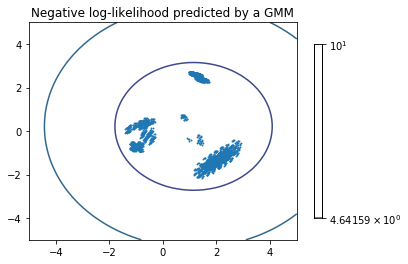

Contour graph for 1 components, trained using covariance type diag


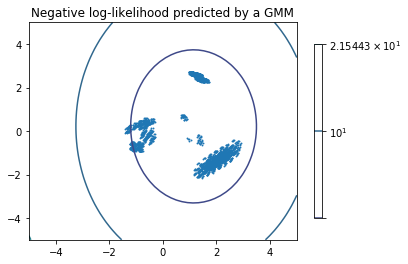

Contour graph for 1 components, trained using covariance type tied


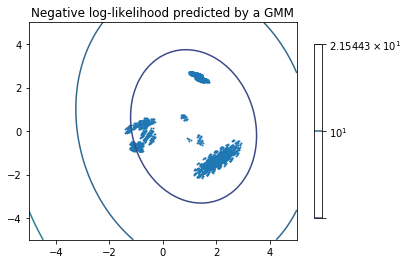

Contour graph for 1 components, trained using covariance type full


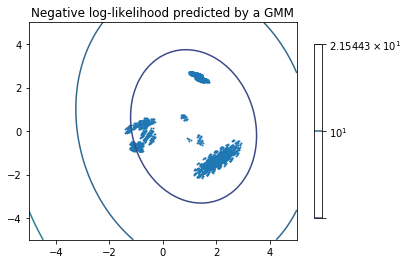

Contour graph for 2 components, trained using covariance type spherical


/Users/clayleach/p3env/lib/python3.7/site-packages/matplotlib/contour.py:1484: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


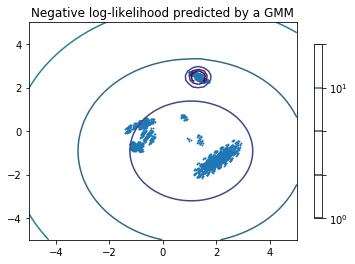

Contour graph for 2 components, trained using covariance type diag


/Users/clayleach/p3env/lib/python3.7/site-packages/matplotlib/contour.py:1484: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


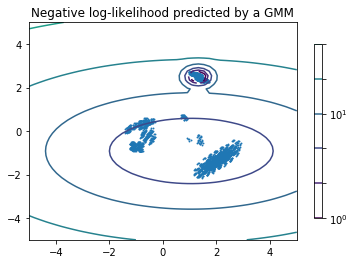

Contour graph for 2 components, trained using covariance type tied


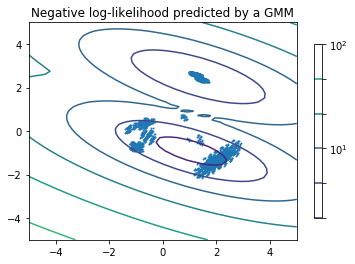

Contour graph for 2 components, trained using covariance type full


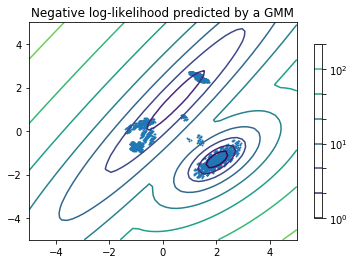

Contour graph for 3 components, trained using covariance type spherical


/Users/clayleach/p3env/lib/python3.7/site-packages/matplotlib/contour.py:1484: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


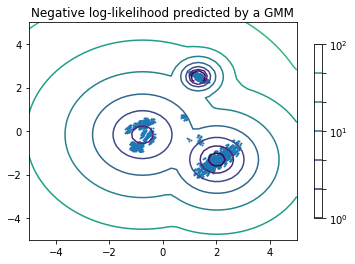

Contour graph for 3 components, trained using covariance type diag


/Users/clayleach/p3env/lib/python3.7/site-packages/matplotlib/contour.py:1484: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


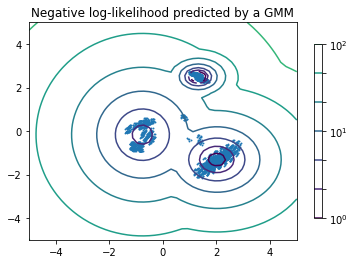

Contour graph for 3 components, trained using covariance type tied


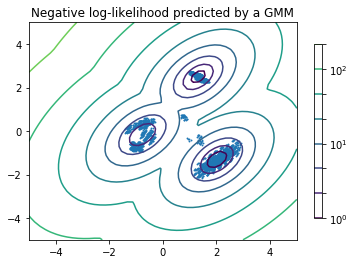

Contour graph for 3 components, trained using covariance type full


/Users/clayleach/p3env/lib/python3.7/site-packages/matplotlib/contour.py:1484: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


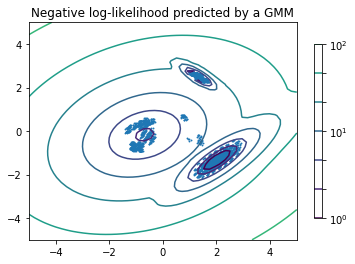

Contour graph for 4 components, trained using covariance type spherical


/Users/clayleach/p3env/lib/python3.7/site-packages/matplotlib/contour.py:1484: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


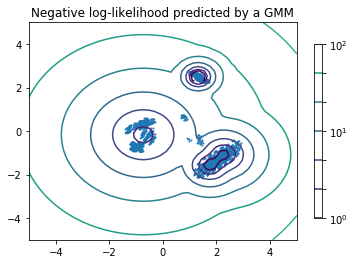

Contour graph for 4 components, trained using covariance type diag


/Users/clayleach/p3env/lib/python3.7/site-packages/matplotlib/contour.py:1484: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


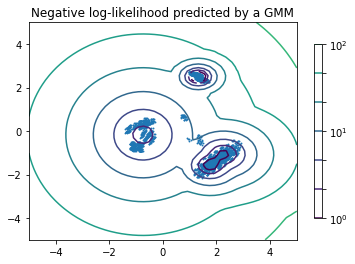

Contour graph for 4 components, trained using covariance type tied


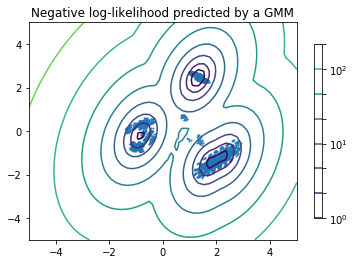

Contour graph for 4 components, trained using covariance type full


/Users/clayleach/p3env/lib/python3.7/site-packages/matplotlib/contour.py:1484: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


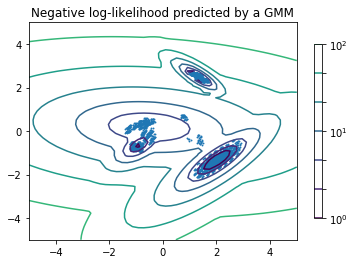

In [8]:
def gmm_positive_examples(df, train_labels, components, covariance_types):
    """
    Plots density contours of positive data, varrying number of components and covariance type
    :param df: feature data
    :param train_labels: features which correspond to df
    :components: the number of gaussians which will be used; will iterate from 1 up to and including this value
    :param covariance_types: list of covariance types to try
    """
    new_train = df[train_labels==1]
    for comp_count in range(1, components+1):
        for covariance in covariance_types:
            try:
                print("Contour graph for %s components, trained using covariance type %s" %(comp_count,covariance))
                gmm = GaussianMixture(n_components=comp_count, covariance_type=covariance)
                gmm.fit(new_train)

                # display predicted scores by the model as a contour plot
                x = np.linspace(-5., 5.)
                y = np.linspace(-5., 5.)
                X, Y = np.meshgrid(x, y)
                XX = np.array([X.ravel(), Y.ravel()]).T
                Z = -gmm.score_samples(XX)
                Z = Z.reshape(X.shape)

                CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                                 levels=np.logspace(0, 3, 10))
                CB = plt.colorbar(CS, shrink=0.8, extend='both')
                plt.scatter(new_train[:, 0], new_train[:, 1], .8)

                plt.title('Negative log-likelihood predicted by a GMM')
                plt.axis('tight')
                plt.show()
            except:
                print("error occured, likely due to invalid covariance selection")
    return

gmm_positive_examples(df, train_labels, 4, ['spherical', 'diag', 'tied', 'full'])

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [9]:
# Use prior pca object to transform our test data set
new_test_data = pca_object.transform(test_data)

In [10]:
def positive_vs_negative_gmm(df, train_label, num_gauss=4, covariance='full'):
    """
    Trains two GMMs, one on positive examples and one on negative examples
    :param df: feature data
    :param train_label: labels which correspond to feature data
    :param num_gauss: number of gaussian components to use in mixture model
    :param covariance: covariance type to use when training GMM
    """
    # Split data into positive and negative subsets
    positive_train = df[train_label==1]
    negative_train = df[train_label==0]
    
    # Train gmm model on positive examples
    gmm_pos = GaussianMixture(n_components=num_gauss, covariance_type=covariance)
    gmm_pos.fit(positive_train)
    
    # Train gmm model on negative examples
    gmm_neg = GaussianMixture(n_components=num_gauss, covariance_type=covariance)
    gmm_neg.fit(negative_train)
    
    return gmm_pos, gmm_neg


gmm_pos, gmm_neg = positive_vs_negative_gmm(df, train_labels)

In [11]:
def use_multi_gmms_to_predict(test_data, gmms, model_prediction_map):
    """
    Takes in test data, a list of GMM models, and a prediction map to make predictions for each sample
    :param test_data: feature data
    :param gmms: list of GMM models
    :param model_prediction_map: dictionary to map a samples predicted value based on model which provides
                                    highest probability
    """
    predictions = []
    for x in range(0,test_data.shape[0]):
        count=0
        best_score = None
        for gmm in gmms:
            score = gmm.score(test_data[x].reshape(1,-1))
            if (best_score is None) or (score > best_score):
                best_score=score
                model = count
            count += 1
        predictions.append(model_prediction_map[model])
    return predictions

# Trivial for this problem, but set up this way to allow for potential flexability if cluster corresponds
# to a different prediction value
model_map = {0:0, 1:1}
predictions = use_multi_gmms_to_predict(new_test_data, [gmm_neg, gmm_pos], model_map)
print("The accuracy using the method is %s%%" %round(accuracy_score(test_labels, predictions)*100,2))

The accuracy using the method is 95.02%


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

## Outlining the paramters associated with each covariance type

Diagonal = num_pca features * components   | Covariance is n*n, but we only care about diagonal which is equal to n
    $$(2*pca)*components*classes$$
Full = num_pca features squared | covariance is n*n and we use every value
    $$(pca + pca^2) * components * classes$$
Tied = num_pca features squared but shared across components
    $$((pca*components) + pca^2) * classes$$
Spherical = num_componets | Single variance number is used
    $$((pca*components)+pca) * classes$$

#### From SKLearn documentation on GMM
    *(n_components,)                        if 'spherical',
    *(n_features, n_features)               if 'tied',
    *(n_components, n_features)             if 'diag',
    *(n_components, n_features, n_features) if 'full'

In [12]:
# Helper functions to determine number of params

def num_params_diag(num_pca,components,classes):
    return ((2*num_pca)*components*classes)

def num_params_full(num_pca,components,classes):
    return ((num_pca + num_pca**2)*components*classes)

def num_params_tied(num_pca,components,classes):
    return (((num_pca*components)+num_pca**2)*classes)

def num_params_spherical(num_pca,components,classes):
    return (((num_pca * components)+num_pca)*classes)



def select_best_under_50params(train_data, train_labels, test_data, test_labels):
    """
    Iterates through combinations of pca components, gaussian components, and covariance types to 
    select model with highest predicted accuracy
    
    :param train_data: raw untransformed training data
    :param train_labels: labels which correspond to training data
    :param test_data: raw untransformed test data
    :param test_labels: labels which correspond to test_data
    """
    best_params = {"score":0,"params":{"covariance":None,"num_pca":None,"gauss_components":None}}
    for covariance in ['spherical', 'diag', 'tied', 'full']:
        for components in range(1,10):
            for num_pca in range(1,10):
                params = 0
                if covariance == 'spherical':
                    params = num_params_spherical(num_pca,components,2)
                elif covariance == 'daig':
                    params = num_params_diag(num_pca,components,2)
                elif covariance == 'tied':
                    params = num_params_tied(num_pca,components,2)
                elif covariance == 'full':
                    params = num_params_full(num_pca,components,2)
                
                if (params > 0) and (params <= 50):
                    pca_object, _, df = pca_data(train_data,num_pca)
                    new_test_data = pca_object.transform(test_data)
    
                    gmm_pos, gmm_neg = positive_vs_negative_gmm(df, train_labels, 
                                                                num_gauss=components, covariance=covariance)
                    cluster_map = {0:0, 1:1}
                    predictions = use_multi_gmms_to_predict(new_test_data, [gmm_neg, gmm_pos], cluster_map)
                    score = round(accuracy_score(test_labels, predictions)*100,2)
                    if score > best_params["score"]:
                        best_params["score"] = score
                        best_params["params"]["covariance"] = covariance
                        best_params["params"]["num_pca"] = num_pca
                        best_params["params"]["gauss_components"] = components
                        print("*********** ATTENTION PLEASE! WE HAVE A NEW BEST SCORE :) ********************")
                    print("The accuracy using %s principal components, %s guassians and covariance type of %s is %s%%"
                          %(num_pca, components, covariance, score ))
    return best_params, gmm_pos, gmm_neg
                    
best_params, best_gmm_pos, best_gmm_neg = select_best_under_50params(train_data,train_labels, test_data, test_labels)

*********** ATTENTION PLEASE! WE HAVE A NEW BEST SCORE :) ********************
The accuracy using 1 principal components, 1 guassians and covariance type of spherical is 84.43%
*********** ATTENTION PLEASE! WE HAVE A NEW BEST SCORE :) ********************
The accuracy using 2 principal components, 1 guassians and covariance type of spherical is 86.03%
*********** ATTENTION PLEASE! WE HAVE A NEW BEST SCORE :) ********************
The accuracy using 3 principal components, 1 guassians and covariance type of spherical is 87.19%
The accuracy using 4 principal components, 1 guassians and covariance type of spherical is 86.3%
The accuracy using 5 principal components, 1 guassians and covariance type of spherical is 87.19%
*********** ATTENTION PLEASE! WE HAVE A NEW BEST SCORE :) ********************
The accuracy using 6 principal components, 1 guassians and covariance type of spherical is 87.81%
The accuracy using 7 principal components, 1 guassians and covariance type of spherical is 87.63%

The accuracy using 1 principal components, 6 guassians and covariance type of full is 91.19%
The accuracy using 1 principal components, 7 guassians and covariance type of full is 91.28%
The accuracy using 1 principal components, 8 guassians and covariance type of full is 91.19%
The accuracy using 1 principal components, 9 guassians and covariance type of full is 91.46%


Based on the above our best parameters are:

    6 principal components, 3 guassians and covariance type of spherical, which yields an accuracy of 96.8%


# End Project 3